In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import glob
import cv2
import pandas as pd
from skimage.feature import graycomatrix, graycoprops
from sklearn.preprocessing import LabelEncoder, StandardScaler
import pandas as pd
import seaborn as sns
import itertools
import lightgbm as lgb
from sklearn import metrics

In [2]:
# Training Images
train_paths = glob.glob("training/**/*.jpg", recursive=True) # list of paths for all images in training folder
train_images = [cv2.imread(path, 0) for path in train_paths] # list of training images
train_labels = [path.split("\\")[1] for path in train_paths] # list of training image labels
# converting to numpy array
train_images = np.array(train_images)
train_labels = np.array(train_labels)

print("Shape of train_images: ", train_images.shape)
print("Shape of train_labels: ", train_labels.shape)
print("Number of Unique Labels: ", len(np.unique(train_labels)))

Shape of train_images:  (219, 75, 150)
Shape of train_labels:  (219,)
Number of Unique Labels:  4


In [3]:
# Validation Images
test_paths = glob.glob("validation/**/*.jpg", recursive=True) # list of paths for all images in validation folder
test_images = [cv2.imread(path, 0) for path in test_paths] # list of validation images
test_labels = [path.split("\\")[1] for path in test_paths] # list of validation image labels
# converting to numpy array
test_images = np.array(test_images)
test_labels = np.array(test_labels)

print("Shape of test_images: ", test_images.shape)
print("Shape of test_labels: ", test_labels.shape)
print("Number of Unique Labels: ", len(np.unique(test_labels)))

Shape of test_images:  (80, 75, 150)
Shape of test_labels:  (80,)
Number of Unique Labels:  4


In [4]:
# Label Encoding Labels ['CR', 'CRP', 'CRT', 'CRTP'] -> [0 , 1, 2, 3]
le = LabelEncoder()
train_labels_enc = le.fit_transform(train_labels)
test_labels_enc = le.transform(test_labels)

In [5]:
x_train, y_train, x_test, y_test = train_images, train_labels_enc, test_images, test_labels_enc

In [6]:
def feature_extractor(image_list: np.ndarray, distances: list, angles: list):
    """ Extract Gray-Level Co-occerance Matrix (GLCM) Features 
        Parameters
        ----------
        image_list -> numpy array of images
        distances  -> list of distances (graycomatrix parameter) 
        angles     -> list of angles    (graycomatrix parameter)

        Returns
        ----------
        Pandas Dataframe of Image features of size I  * (D * A) where,
        I -> Number of images
        D -> Number of distances
        A -> Number of Angles
    """
    img_features_df = pd.DataFrame() # empty dataframe to append feature values
    
    # iterate through each image
    for img in image_list:
        df = pd.DataFrame() # empty dataframe store feature values for 'img' 
        params = list(itertools.product(distances, angles)) # possible pairs of distances and angles
        # glcm_features = ["energy", "correlation", "dissimilarity", "homogeinity", "contrast", "ASM"]

        # iterate for each distance and angle pair, calculate glcm and extract features
        for (d, ang) in params:
            GLCM = graycomatrix(img, [d], [np.deg2rad(ang)])
            df["Correlation_"+str(d)+"_"+str(ang)] = graycoprops(GLCM, "correlation")[0]
            df["Dissimilarity_"+str(d)+"_"+str(ang)] = graycoprops(GLCM, "dissimilarity")[0]
            df["Homogeneity_"+str(d)+"_"+str(ang)] = graycoprops(GLCM, "homogeneity")[0]
            df["Contrast_"+str(d)+"_"+str(ang)] = graycoprops(GLCM, "contrast")[0]
            df["ASM_"+str(d)+"_"+str(ang)] = graycoprops(GLCM, "ASM")[0]
            df["Energy_"+str(d)+"_"+str(ang)] = graycoprops(GLCM, "energy")[0]
        
        img_features_df =  pd.concat([img_features_df, df], ignore_index=True) # append extracted features

    return img_features_df

In [7]:
# Define GLCM Features parameters distances and angles
dists = [1, 2, 3, 4] # distances
angs  = [0, 45, 90, 135] # angles

In [8]:
x_features = feature_extractor(x_train, dists, angs) # generate glcm features for training data
scaler = StandardScaler()
x_features[x_features.columns] = scaler.fit_transform(x_features[x_features.columns]) # Scaling Features

In [9]:
print("Shape of GLCM Features for Training: ", x_features.shape)
x_features

Shape of GLCM Features for Training:  (219, 96)


,Correlation_1_0,Dissimilarity_1_0,Homogeneity_1_0,Contrast_1_0,ASM_1_0,Energy_1_0,Correlation_1_45,Dissimilarity_1_45,Homogeneity_1_45,Contrast_1_45,...,Homogeneity_4_90,Contrast_4_90,ASM_4_90,Energy_4_90,Correlation_4_135,Dissimilarity_4_135,Homogeneity_4_135,Contrast_4_135,ASM_4_135,Energy_4_135
0,-1.346732,-1.021034,0.640791,-1.046796,1.566989,1.570450,-1.422533,-1.114552,0.692316,-1.147336,...,1.680940,-1.473384,2.178928,2.146077,-0.842129,-1.650088,1.668827,-1.464744,2.198839,2.167608
1,-1.049394,-1.745044,1.726539,-1.479578,3.307186,2.981924,-1.126798,-1.839865,1.915676,-1.599434,...,1.957926,-1.684936,3.714809,3.386047,-1.254564,-2.092762,2.674905,-1.728029,3.743329,3.414899
2,-0.459369,-1.613520,1.627818,-1.353202,2.566844,2.406780,-0.476775,-1.650995,1.746900,-1.458420,...,1.989357,-1.468925,2.636364,2.530782,-1.294781,-1.705368,1.837474,-1.464184,2.665269,2.559930
3,-1.057850,-0.294171,-0.270474,-0.501637,0.271275,0.350292,-1.205279,-0.354418,-0.106020,-0.531911,...,0.286125,-0.809854,0.651190,0.738183,-0.642553,-0.947486,0.752235,-0.957358,0.674427,0.762755
4,-2.040004,-1.043052,0.568494,-1.013158,1.779739,1.754940,-1.997290,-1.166219,0.866489,-1.160251,...,2.022066,-1.520107,2.416144,2.347376,-1.250765,-1.728114,1.384132,-1.522804,2.472746,2.399801
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214,0.531336,-0.470648,0.150216,-0.465452,-0.270207,-0.222437,0.690347,-0.559053,0.119401,-0.572888,...,-0.106218,-0.480077,-0.383352,-0.362790,0.694402,-0.260545,-0.094115,-0.381406,-0.373517,-0.352611
215,0.420237,-0.386346,0.132469,-0.438787,-0.184551,-0.128754,0.504667,-0.482866,0.159257,-0.510373,...,0.216505,-0.366571,-0.250936,-0.213085,0.392066,-0.258577,-0.072605,-0.381065,-0.258792,-0.222632
216,0.953899,-1.079506,0.922161,-1.079307,0.220577,0.298521,0.965420,-1.063047,0.954259,-1.100778,...,0.349173,-0.862123,-0.065058,-0.007716,0.634128,-0.668554,0.186434,-0.805210,-0.094591,-0.040324
217,0.610613,-0.530390,0.357580,-0.597147,-0.282245,-0.235704,0.569752,-0.454767,-0.004804,-0.568511,...,0.108451,-0.419951,-0.372376,-0.350269,0.312249,-0.249502,-0.078918,-0.375069,-0.332288,-0.305645


In [10]:
# Predict on Test data
# Extract features from test data and reshape, just like training data
test_features = feature_extractor(x_test, dists, angs)
test_features[test_features.columns] = scaler.transform(test_features[test_features.columns]) # Scaling Features

In [11]:
print("Shape of GLCM Features for Validation: ", test_features.shape)

Shape of GLCM Features for Validation:  (80, 96)


In [12]:
# LightGBM Model Training
d_train = lgb.Dataset(x_features, label=y_train)
d_test = lgb.Dataset(test_features, label=y_test)

# https://lightgbm.readthedocs.io/en/latest/Parameters.html

lgbm_params = {
              'learning_rate':0.05, 
              'boosting_type':'dart',    
              'objective':'multiclass',
              'metric': 'multi_logloss',
              'num_leaves': 100,
              'max_depth': 10,
              'num_class':4
            }  

lgb_model = lgb.train(lgbm_params, d_train, 100) 

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005792 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7161
[LightGBM] [Info] Number of data points in the train set: 219, number of used features: 96
[LightGBM] [Info] Start training from score -1.418780
[LightGBM] [Info] Start training from score -1.381739
[LightGBM] [Info] Start training from score -1.363720
[LightGBM] [Info] Start training from score -1.381739
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with pos

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

In [13]:
# Predict on test
test_prediction = lgb_model.predict(test_features)

In [14]:
test_prediction=np.argmax(test_prediction, axis=1) # get the class with the highest probability value
test_prediction

array([0, 3, 2, 0, 0, 0, 1, 2, 0, 0, 1, 0, 0, 3, 0, 0, 0, 1, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 2, 2, 2, 0,
       2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3], dtype=int64)

In [15]:
# Inverse le transform to get original label back. 
test_prediction = le.inverse_transform(test_prediction)
test_prediction # predicted labels for test images

array(['CR', 'CRTP', 'CRT', 'CR', 'CR', 'CR', 'CRP', 'CRT', 'CR', 'CR',
       'CRP', 'CR', 'CR', 'CRTP', 'CR', 'CR', 'CR', 'CRP', 'CR', 'CR',
       'CRP', 'CRP', 'CRP', 'CRP', 'CRP', 'CRP', 'CRP', 'CRP', 'CRP',
       'CR', 'CRP', 'CRP', 'CRP', 'CRP', 'CRP', 'CRP', 'CRP', 'CRP',
       'CRTP', 'CRP', 'CRT', 'CRT', 'CRT', 'CR', 'CRT', 'CRT', 'CRT',
       'CR', 'CRT', 'CRT', 'CRT', 'CRT', 'CRT', 'CRT', 'CRT', 'CRT',
       'CRT', 'CRT', 'CRT', 'CRT', 'CRP', 'CRTP', 'CRTP', 'CRTP', 'CRTP',
       'CRTP', 'CRTP', 'CRTP', 'CRTP', 'CRTP', 'CRTP', 'CRTP', 'CRTP',
       'CRTP', 'CRTP', 'CRTP', 'CRTP', 'CRTP', 'CRTP', 'CRTP'],
      dtype='<U4')

In [16]:
test_labels # True labels of test images

array(['CR', 'CR', 'CR', 'CR', 'CR', 'CR', 'CR', 'CR', 'CR', 'CR', 'CR',
       'CR', 'CR', 'CR', 'CR', 'CR', 'CR', 'CR', 'CR', 'CR', 'CRP', 'CRP',
       'CRP', 'CRP', 'CRP', 'CRP', 'CRP', 'CRP', 'CRP', 'CRP', 'CRP',
       'CRP', 'CRP', 'CRP', 'CRP', 'CRP', 'CRP', 'CRP', 'CRP', 'CRP',
       'CRT', 'CRT', 'CRT', 'CRT', 'CRT', 'CRT', 'CRT', 'CRT', 'CRT',
       'CRT', 'CRT', 'CRT', 'CRT', 'CRT', 'CRT', 'CRT', 'CRT', 'CRT',
       'CRT', 'CRT', 'CRTP', 'CRTP', 'CRTP', 'CRTP', 'CRTP', 'CRTP',
       'CRTP', 'CRTP', 'CRTP', 'CRTP', 'CRTP', 'CRTP', 'CRTP', 'CRTP',
       'CRTP', 'CRTP', 'CRTP', 'CRTP', 'CRTP', 'CRTP'], dtype='<U4')

In [17]:
# Accuracy
print ("Accuracy:", metrics.accuracy_score(test_labels, test_prediction))

Accuracy: 0.85


In [18]:
# Precision 
print("Precision:\n[CR, CRP, CRT, CRTP]\t", metrics.precision_score(test_labels, test_prediction, average=None))

Precision:
[CR, CRP, CRT, CRTP]	 [0.8125     0.81818182 0.9        0.86363636]


In [19]:
# Recall
print("Recall:\n[CR, CRP, CRT, CRTP]\t", metrics.recall_score(test_labels, test_prediction, average=None))

Recall:
[CR, CRP, CRT, CRTP]	 [0.65 0.9  0.9  0.95]


In [20]:
# F1 Score
print("F1 Scores:\n[CR, CRP, CRT, CRTP]\t", metrics.f1_score(test_labels, test_prediction, average=None))

F1 Scores:
[CR, CRP, CRT, CRTP]	 [0.72222222 0.85714286 0.9        0.9047619 ]


In [21]:
def gen_annotations(cf_matrix):
    """
    Generates Annotation for each cell in confusion matrix
    args:
        cf_matrix: confusion matrix (numpy array)
    """
    sums = np.sum(cf_matrix, axis=1, keepdims=True) # sum of each row
    cf_perc = 100*cf_matrix/sums # converting to percentage
    annot = np.empty_like(cf_matrix).astype(str) # creating a empty numpy array to store annotations for each cell
    # iterate through each cell and store the annotation
    rows, cols = cf_matrix.shape 
    for i in range(rows):
        for j in range(cols):
            val = cf_matrix[i, j]
            perc_val = cf_perc[i, j]
            if val == 0: 
                annot[i, j] = '0'
            else:
                sum_val = sums[i][0]
                annot[i, j] = "%.1f%%\n(%d/%d)" % (perc_val, val, sum_val)
    return annot   

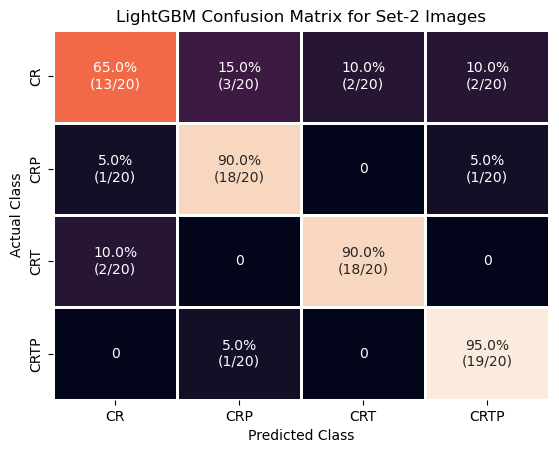

In [22]:
# Plot confusion matrix
cm = metrics.confusion_matrix(test_labels, test_prediction)
annot = gen_annotations(cm)
fig = sns.heatmap(cm, annot=annot, linewidth=1, fmt='', cbar=False,
            xticklabels=['CR', 'CRP', 'CRT', 'CRTP'],
            yticklabels=['CR', 'CRP', 'CRT', 'CRTP']).get_figure()

plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')
plt.title('LightGBM Confusion Matrix for Set-2 Images')
plt.show()
fig.savefig("plots/lgb/cfmatrix_lgb_set_2.png", dpi=600)

## Shap Analysis

In [22]:
import shap

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [23]:
# get shap values
shap_values = shap.TreeExplainer(lgb_model).shap_values(test_features)

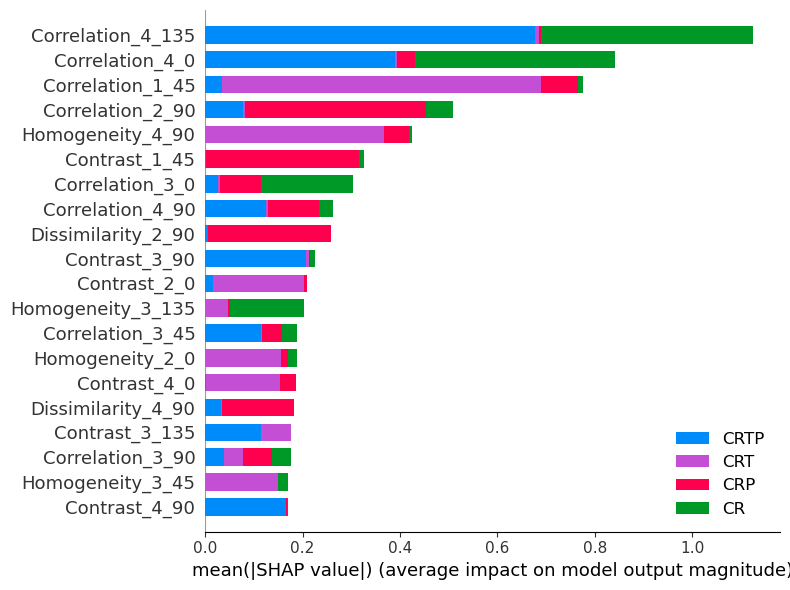

In [24]:
# plot summary
shap.summary_plot(shap_values, test_features, class_names=["CR", "CRP", "CRT", "CRTP"], plot_size=[8,6], show=False)
plt.savefig("plots/lgb/shap_summary_all.png", dpi=600)

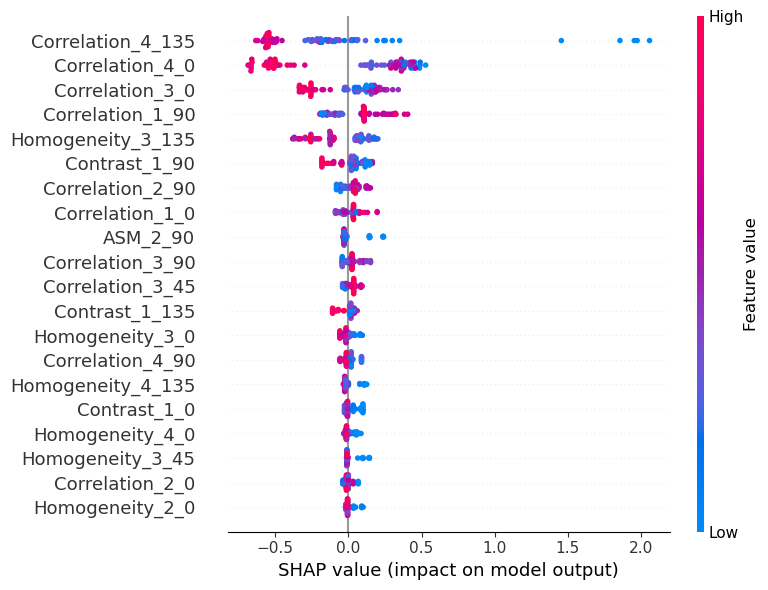

In [25]:
shap.summary_plot(shap_values[0], test_features, plot_size=[8,6], show=False) # summary plot for 'CR' class
plt.savefig("plots/lgb/shap_summary_CR.png", dpi=600)

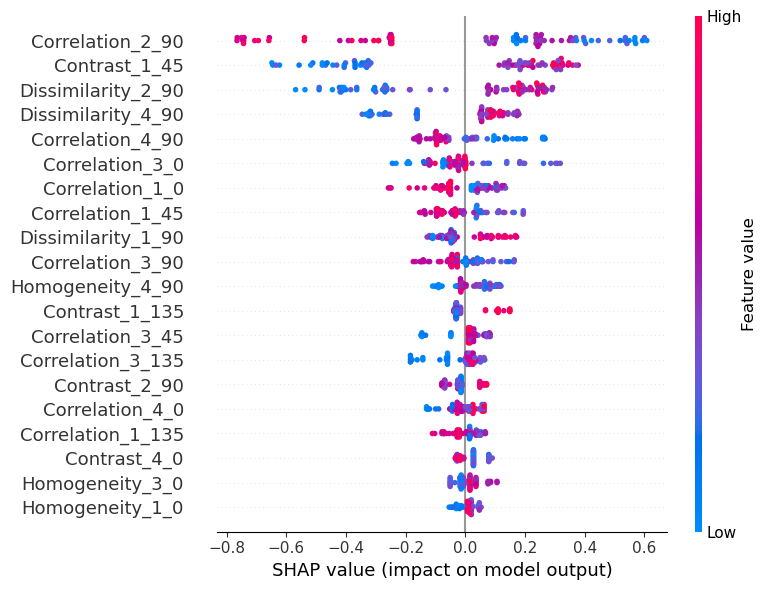

In [26]:
shap.summary_plot(shap_values[1], test_features, plot_size=[8,6], show=False) # summary plot for 'CRP' class
plt.savefig("plots/lgb/shap_summary_CRP.png", dpi=600)

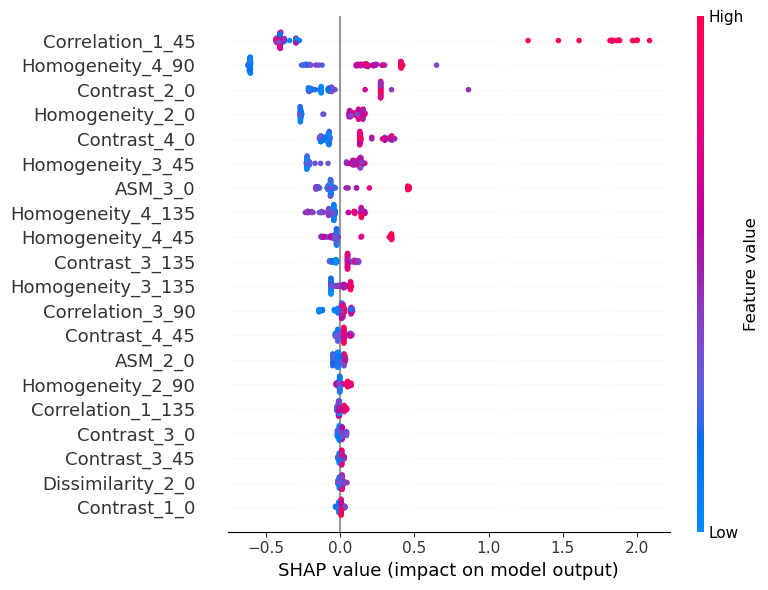

In [27]:
shap.summary_plot(shap_values[2], test_features, plot_size=[8,6], show=False) # summary plot for 'CRT' class
plt.savefig("plots/lgb/shap_summary_CRT.png", dpi=600)

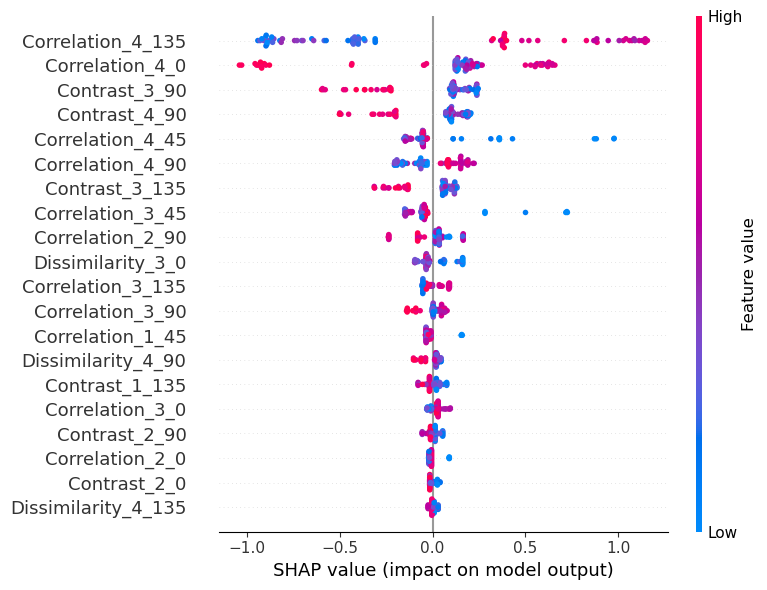

In [28]:
shap.summary_plot(shap_values[3], test_features, plot_size=[8,6], show=False) # summary plot for 'CRTP' class
plt.savefig("plots/lgb/shap_summary_CRTP.png", dpi=600)

## Cross Validation

In [29]:
from sklearn.model_selection import KFold

In [30]:
# Merge all the training and test image features and labels
all_features = pd.concat([x_features, test_features], ignore_index=True)
all_labels_enc = np.append(train_labels_enc, test_labels_enc)

In [31]:
kf = KFold(n_splits=10, shuffle=True, random_state=42)
acc_per_fold = []
# iterate through each fold
for train_idx, test_idx in kf.split(all_features):
    X_train, X_test = all_features.iloc[train_idx], all_features.iloc[test_idx]
    y_train, y_test = all_labels_enc[train_idx], all_labels_enc[test_idx]
    # Create datasets
    train_data = lgb.Dataset(X_train, label=y_train)
    test_data = lgb.Dataset(X_test, label=y_test)
    # train model     
    model = lgb.train(lgbm_params, train_data, 100)
    # predict label probability
    y_pred = model.predict(X_test)
    # get the class with the highest probability
    y_pred_labels = np.argmax(y_pred, axis=1)

    # Calculate accuracy
    acc = metrics.accuracy_score(y_test, y_pred_labels)
    acc_per_fold.append(acc)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002562 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8697
[LightGBM] [Info] Number of data points in the train set: 269, number of used features: 96
[LightGBM] [Info] Start training from score -1.375204
[LightGBM] [Info] Start training from score -1.390019
[LightGBM] [Info] Start training from score -1.405057
[LightGBM] [Info] Start training from score -1.375204
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with pos

In [32]:
# Average Accuracy Score
avg_accuracy =  np.mean(acc_per_fold)
print(f'Average Accuracy: {avg_accuracy:.4f}')

Average Accuracy: 0.8497
